# WhiteboxTools Tutorial - Hydrological and Geomorphometric Analysis

## Overview

WhiteboxTools is an advanced geospatial data analysis platform with over 500 tools specialized in hydrological modeling, terrain analysis, and LiDAR processing. Originally developed by Dr. John Lindsay at the University of Guelph, it is written in Rust for exceptional performance.

## What You'll Learn

This tutorial covers five hydrological and geomorphometric analyses: Flow Accumulation using the D-Infinity algorithm for multi-directional flow modeling, Stream Network Extraction from flow accumulation data, Topographic Wetness Index (TWI) for predicting moisture patterns, Geomorphons for pattern-based landform classification, and Downslope Index for measuring gravitational potential.

## Prerequisites

This notebook requires the `watershed_dem.tif` file created by running Notebook 03 (Watershed Delineation). The configuration file `watershed_analysis.json` from Notebook 01 must also be present.

## Setup: Load Configuration and Imports

This cell loads the configuration and imports required libraries. WhiteboxTools is accessed via command-line interface, with the executable path specified in the configuration file.

In [54]:
import json
import os
import subprocess
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# Load configuration
with open('watershed_analysis.json', 'r') as f:
    config = json.load(f)

# Create output directories
os.makedirs(config["temp_dir"], exist_ok=True)
os.makedirs(config["output_dir"], exist_ok=True)

# Use the watershed DEM created in Step 03
watershed_dem = os.path.join(config['output_dir'], 'watershed_dem.tif')

# Check if watershed DEM exists
if not os.path.exists(watershed_dem):
    raise FileNotFoundError(
        f"watershed_dem.tif not found at {watershed_dem}. "
        "Please run 03_Watershed_Delineation.ipynb first!"
    )

print("Configuration loaded")
print(f"DEM used for processing: {watershed_dem}")
print(f"WhiteboxTools: {config['whitebox_tools']}")
print(f"Output directory: {config['output_dir']}")


Configuration loaded
DEM used for processing: results/watershed_dem.tif
WhiteboxTools: /opt/conda/envs/pygile/bin/whitebox_tools
Output directory: results


## Helper Functions for WhiteboxTools

This cell defines helper functions for WhiteboxTools processing:

**`run_whitebox_tool(tool_name, parameters)`**: Executes WhiteboxTools commands via the command line. Tools are called with their specific parameter flags.

**`visualize_raster(filepath, title, cmap)`**: Creates matplotlib visualizations with percentile clipping to handle outliers.

**`compute_statistics(filepath)`**: Calculates min, max, mean, and standard deviation for raster data.

In [55]:
def run_whitebox_tool(tool_name, parameters, verbose=False):
    """
    Execute a WhiteboxTools command
    
    Parameters:
    -----------
    tool_name : str
        Name of the WhiteboxTools tool to run
    parameters : dict
        Dictionary of parameter names and values
    verbose : bool
        Print command output
    """
    cmd = [config['whitebox_tools'], f'--run={tool_name}']
    
    for key, value in parameters.items():
        cmd.append(f'--{key}={value}')
    
    if verbose:
        print(f"Running: {' '.join(cmd)}")
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Error running WhiteboxTools:")
        print(result.stderr)
        raise Exception(f"WhiteboxTools {tool_name} failed")
    
    if verbose:
        print("Complete")
    
    return result


def visualize_raster(file_path, title, cmap='viridis', figsize=(10, 8), percentile=(2, 98), 
                     log_scale=False, colorbar_label=None):
    """
    Visualize a raster file - improved version with log scale option
    """
    from rasterio.warp import transform_bounds
    from pyproj import CRS

    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
        extent = transform_bounds(
            src.crs,
            CRS.from_epsg(32645),  # UTM zone you are using
            *src.bounds
        )


    
    # Get valid data
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    if log_scale and len(valid_data) > 0:
        # Use log scale for flow accumulation type data
        positive_data = valid_data[valid_data > 0]
        if len(positive_data) > 0:
            vmin = np.percentile(positive_data, percentile[0])
            vmax = np.percentile(positive_data, percentile[1])
            norm = colors.LogNorm(vmin=max(vmin, 1), vmax=vmax)
            im = ax.imshow(data, cmap=cmap, extent=extent, aspect='equal', norm=norm)
        else:
            im = ax.imshow(data, cmap=cmap, extent=extent, aspect='equal')
    else:
        # Standard percentile scaling
        if len(valid_data) > 0:
            vmin, vmax = np.percentile(valid_data, percentile)
        else:
            vmin, vmax = np.nanmin(data), np.nanmax(data)
        im = ax.imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    ax.set_xlabel('Easting (m)', fontsize=10)
    ax.set_ylabel('Northing (m)', fontsize=10)
    
    ax.ticklabel_format(style='plain', useOffset=False)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.03)
    cbar.ax.tick_params(labelsize=9)
    if colorbar_label:
        cbar.set_label(colorbar_label, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()


def compute_statistics(file_path):
    """
    Compute basic statistics for a raster file
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
    
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    
    return {
        'min': np.min(valid_data) if len(valid_data) > 0 else np.nan,
        'max': np.max(valid_data) if len(valid_data) > 0 else np.nan,
        'mean': np.mean(valid_data) if len(valid_data) > 0 else np.nan,
        'std': np.std(valid_data) if len(valid_data) > 0 else np.nan,
        'median': np.median(valid_data) if len(valid_data) > 0 else np.nan
    }


print("Helper functions loaded")

Helper functions loaded


## Step 0: Preprocessing - Fill Depressions

Real-world DEMs often contain depressions (sinks or pits) where cells are surrounded by higher terrain. These can be artifacts from data collection or real features like sinkholes. For hydrological modeling, depressions cause flow to become trapped, fragmenting stream networks and preventing proper watershed delineation.

WhiteboxTools provides the `FillDepressions` tool which uses an efficient algorithm to fill all depressions to their pour point elevation, creating a hydrologically-correct DEM suitable for flow analysis.

**WhiteboxTools Command**: `FillDepressions`

In [56]:
print("Filling depressions in DEM...\n")

# Output file
filled_dem = os.path.join(config['output_dir'], 'wb_filled_dem.tif')

# Run depression filling
run_whitebox_tool(
    tool_name='FillDepressions',
    parameters={
        'dem': watershed_dem,
        'output': filled_dem
    }
)

print(f"\nFilled DEM saved to: {filled_dem}")

Filling depressions in DEM...


Filled DEM saved to: results/wb_filled_dem.tif


## 1. Flow Accumulation (D-Infinity Algorithm)

Flow accumulation calculates the number of upslope cells that flow into each cell, representing contributing area, potential water volume, and stream channel locations.

The D-Infinity algorithm allows flow to be partitioned between two downslope neighbors based on slope angle, providing more realistic flow distribution on hillslopes compared to traditional D8 which only allows flow to one of 8 neighbors. D-Infinity produces smoother accumulation patterns without artificial parallel flow lines.

**WhiteboxTools Commands**: `DInfPointer` followed by `DInfFlowAccumulation`

In [57]:
print("Calculating D-Infinity Flow Accumulation...\n")

# Output files
dinf_pointer = os.path.join(config['output_dir'], 'wb_dinf_pointer.tif')
dinf_flow_accum = os.path.join(config['output_dir'], 'wb_dinf_flow_accum.tif')

# Step 1: Calculate D-Infinity flow directions
run_whitebox_tool(
    tool_name='DInfPointer',
    parameters={
        'dem': filled_dem,
        'output': dinf_pointer
    }
)
print("Flow directions calculated")

# Step 2: Calculate D-Infinity flow accumulation
run_whitebox_tool(
    tool_name='DInfFlowAccumulation',
    parameters={
        'dem': filled_dem,
        'output': dinf_flow_accum,
        'out_type': 'cells'
    }
)

print(f"\nD-Infinity flow accumulation saved to: {dinf_flow_accum}")

Calculating D-Infinity Flow Accumulation...

Flow directions calculated

D-Infinity flow accumulation saved to: results/wb_dinf_flow_accum.tif


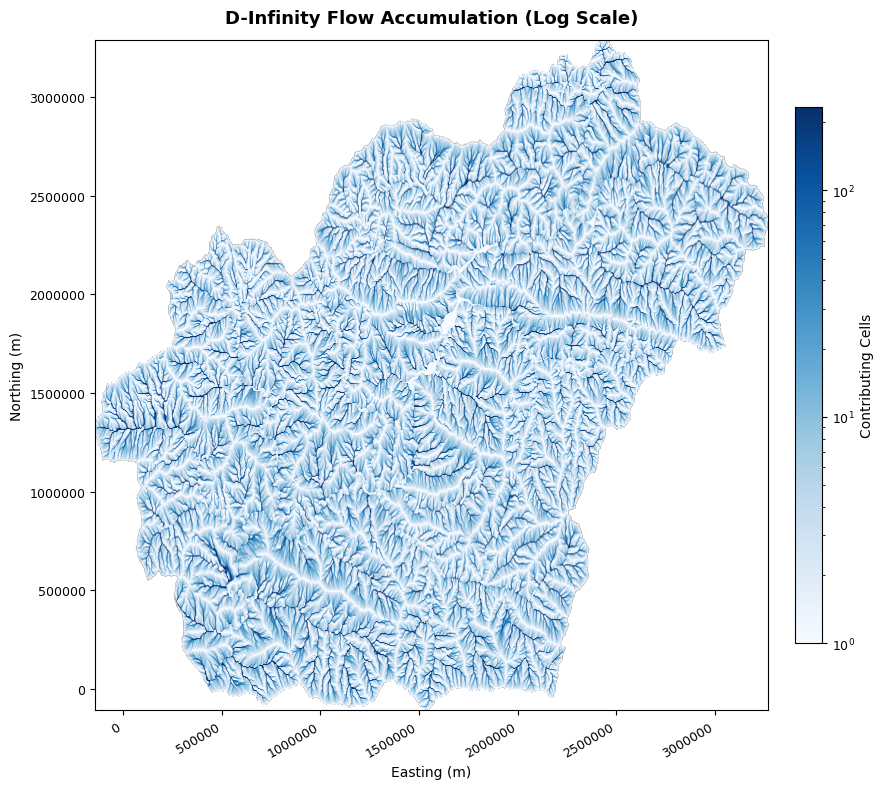

In [58]:
# Visualize Flow Accumulation with log scale
# Log scale is essential because flow accumulation spans many orders of magnitude
visualize_raster(
    dinf_flow_accum,
    title='D-Infinity Flow Accumulation (Log Scale)',
    cmap='Blues',
    log_scale=True,
    colorbar_label='Contributing Cells'
)

### Interpreting Flow Accumulation

Light blue areas with low values indicate ridge tops and divides with small contributing areas and minimal upslope drainage. Medium blue areas with moderate values indicate hillslopes and valleys with moderate drainage convergence and potential gully initiation points. Dark blue areas with high values indicate stream channels and valley bottoms with large contributing areas and high water and sediment flux. The logarithmic scale reveals the network structure more clearly than a linear scale.

## 2. Stream Network Extraction

Stream network extraction identifies channel locations by applying a threshold to flow accumulation. Cells with accumulation above the threshold are classified as streams.

The threshold value determines stream density. A low threshold (e.g., 100 cells) produces a dense network including ephemeral channels. A medium threshold (e.g., 500 cells) produces a moderate network of perennial streams. A high threshold (e.g., 1000+ cells) produces only major rivers. The appropriate threshold depends on climate, geology, DEM resolution, and intended application.

**WhiteboxTools Command**: `ExtractStreams`

In [59]:
print("Extracting Stream Network...\n")

# Output file
streams = os.path.join(config['output_dir'], 'wb_streams.tif')

# Extract streams using a threshold
# Threshold of 500 cells gives a moderate density network
run_whitebox_tool(
    tool_name='ExtractStreams',
    parameters={
        'flow_accum': dinf_flow_accum,
        'output': streams,
        'threshold': 500
    }
)

print(f"\nStream network saved to: {streams}")

Extracting Stream Network...


Stream network saved to: results/wb_streams.tif


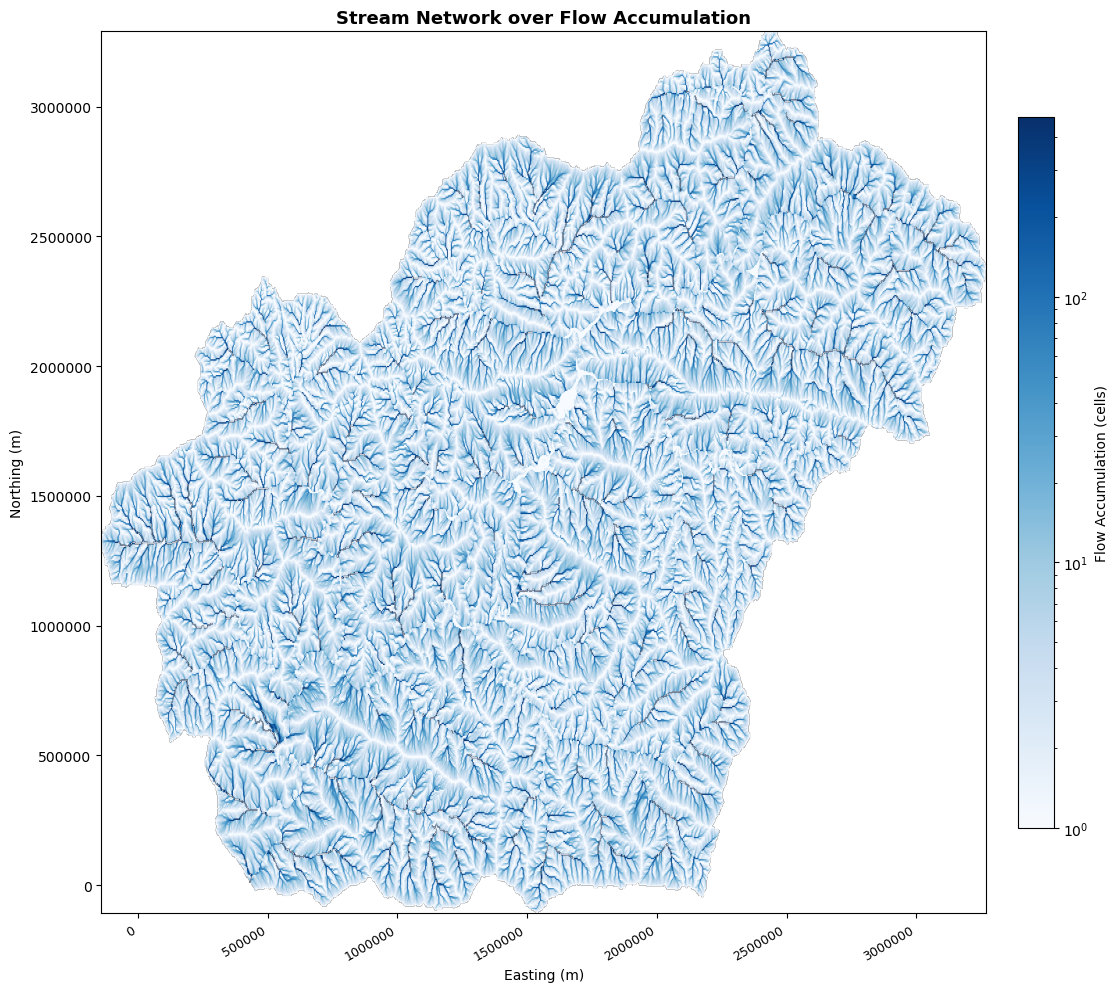

In [60]:
from rasterio.warp import transform_bounds
from pyproj import CRS

# Visualize stream network overlaid on flow accumulation
fig, ax = plt.subplots(figsize=(12, 10))

# Read flow accumulation
with rasterio.open(dinf_flow_accum) as src:
    flow_data = src.read(1, masked=True)
    extent = transform_bounds(
        src.crs,
        CRS.from_epsg(32645),  # UTM zone
        *src.bounds
    )

# Read streams
with rasterio.open(streams) as src:
    stream_data = src.read(1, masked=True)

# Plot flow accumulation as background (log scale)
valid_flow = flow_data[~flow_data.mask]
positive_flow = valid_flow[valid_flow > 0]
vmin = np.percentile(positive_flow, 1)
vmax = np.percentile(positive_flow, 99)
im = ax.imshow(
    flow_data,
    cmap='Blues',
    extent=extent,
    aspect='equal',
    norm=colors.LogNorm(vmin=max(vmin, 1), vmax=vmax)
)

# Overlay streams in red
stream_mask = np.ma.masked_where(stream_data == 0, stream_data)
ax.imshow(stream_mask, cmap='Reds', extent=extent, aspect='equal', alpha=0.8)

ax.set_title('Stream Network over Flow Accumulation', fontsize=13, fontweight='bold')
ax.set_xlabel('Easting (m)', fontsize=10)
ax.set_ylabel('Northing (m)', fontsize=10)
ax.ticklabel_format(style='plain', useOffset=False)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)

cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.03)
cbar.set_label('Flow Accumulation (cells)', fontsize=10)

plt.tight_layout()
plt.show()
plt.close()


### Interpreting Stream Networks

Red lines represent extracted stream channels based on the flow accumulation threshold, while the blue background shows flow accumulation revealing the full drainage pattern. Streams typically form dendritic patterns with visible convergence where tributaries meet. Stream density relates to climate, geology, and vegetation. If the network appears too dense or sparse, adjust the threshold value accordingly.

## 3. Topographic Wetness Index (TWI)

The Topographic Wetness Index (also called Compound Topographic Index) predicts areas of moisture accumulation based on topography using the formula TWI = ln(α / tan(β)), where α is specific catchment area and β is slope angle.

TWI balances contributing area (more upslope area means more water input) against slope (steeper slopes drain faster). High TWI values indicate potential wetlands and saturated soils in flat areas with large contributing areas. Low TWI values indicate well-drained conditions on steep slopes or ridgetops.

**WhiteboxTools Commands**: `Slope`, `DInfFlowAccumulation` with SCA output, then `WetnessIndex`

In [61]:
print("Calculating Topographic Wetness Index (TWI)...\n")

# Step 1: Calculate slope
slope = os.path.join(config['output_dir'], 'wb_slope.tif')
run_whitebox_tool(
    tool_name='Slope',
    parameters={'dem': filled_dem, 'output': slope}
)
print("Slope calculated")

# Step 2: Calculate specific catchment area (SCA)
sca = os.path.join(config['output_dir'], 'wb_sca.tif')
run_whitebox_tool(
    tool_name='DInfFlowAccumulation',
    parameters={
        'dem': filled_dem,
        'output': sca,
        'out_type': 'sca'
    }
)
print("SCA calculated")

# Step 3: Calculate TWI
twi = os.path.join(config['output_dir'], 'wb_twi.tif')
run_whitebox_tool(
    tool_name='WetnessIndex',
    parameters={
        'sca': sca,
        'slope': slope,
        'output': twi
    }
)

print(f"\nTWI saved to: {twi}")

Calculating Topographic Wetness Index (TWI)...

Slope calculated
SCA calculated

TWI saved to: results/wb_twi.tif


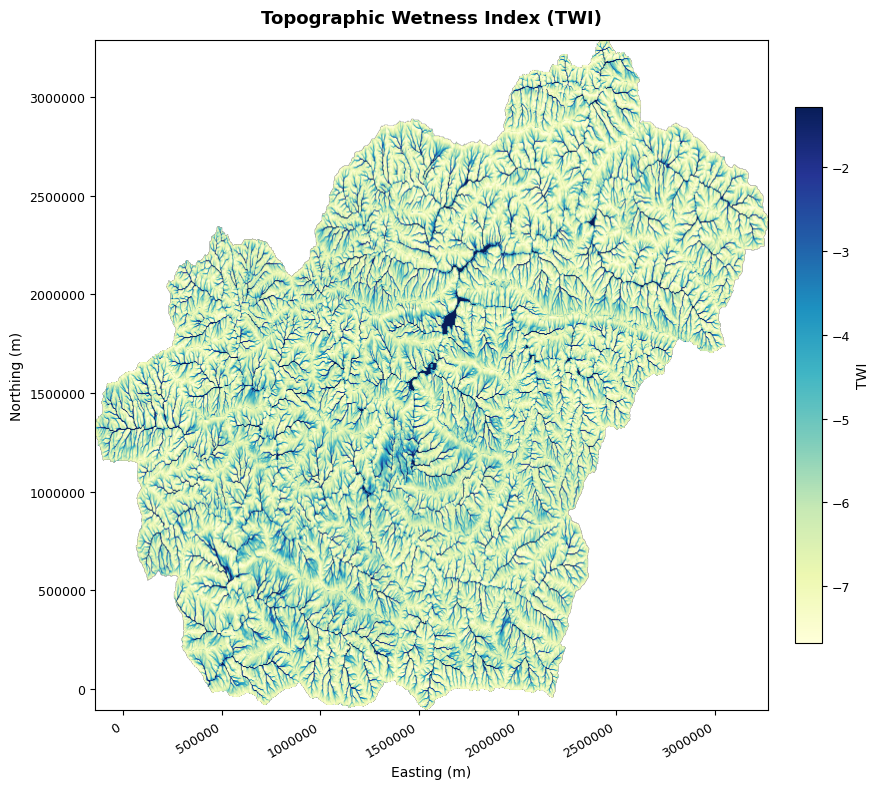

In [62]:
# Visualize TWI
visualize_raster(
    twi,
    title='Topographic Wetness Index (TWI)',
    cmap='YlGnBu',
    percentile=(2, 98),
    colorbar_label='TWI'
)

### Interpreting TWI

Yellow and light colors indicate low TWI values (around -7 to -5 in this dataset) found on ridge tops and upper slopes with steep terrain and well-drained, dry soil conditions. Light blue and cyan colors indicate moderate TWI values (around -5 to -3) found on mid-slopes with intermediate moisture levels. Dark blue colors indicate high TWI values (around -3 to -2) found in valley bottoms and channels where moisture accumulates, indicating areas prone to saturation during rainfall events.

Note: TWI values can be negative when the specific catchment area divided by slope tangent is less than 1, which is common in steep mountainous terrain like this watershed. The relative pattern remains valid - higher (less negative) values indicate wetter conditions.

## 4. Geomorphons - Pattern-Based Landform Classification

Geomorphons (geomorphological phonotypes) is an innovative pattern recognition method for automated landform classification developed by Jasiewicz and Stepinski (2013). Unlike traditional methods that measure slope or curvature, geomorphons use a line-of-sight approach: from each cell, rays are cast in 8 directions and each is classified as higher, lower, or similar to the center cell. This creates a ternary pattern (with 3^8 = 6561 possible combinations) that maps to 10 fundamental landform types.

The 10 landform classes are: flat, peak, ridge, shoulder, spur, slope, hollow, footslope, valley, and pit. This method is scale-independent and robust to noise.

**WhiteboxTools Command**: `Geomorphons`

In [63]:
print("Calculating Geomorphon Landform Classification...\n")

# Output file
geomorphons = os.path.join(config['output_dir'], 'wb_geomorphons.tif')

# Use the UTM-projected DEM instead
watershed_dem_utm = os.path.join(config['output_dir'], 'watershed_dem_utm.tif')

# Calculate geomorphons
run_whitebox_tool(
    tool_name='Geomorphons',
    parameters={
        'dem': watershed_dem_utm,  # Use projected DEM
        'output': geomorphons,
        'search': 50,
        'threshold': 1.0,
        'tdist': 0,
        'forms': 'true'
    }
)

print(f"\nGeomorphons saved to: {geomorphons}")

Calculating Geomorphon Landform Classification...


Geomorphons saved to: results/wb_geomorphons.tif


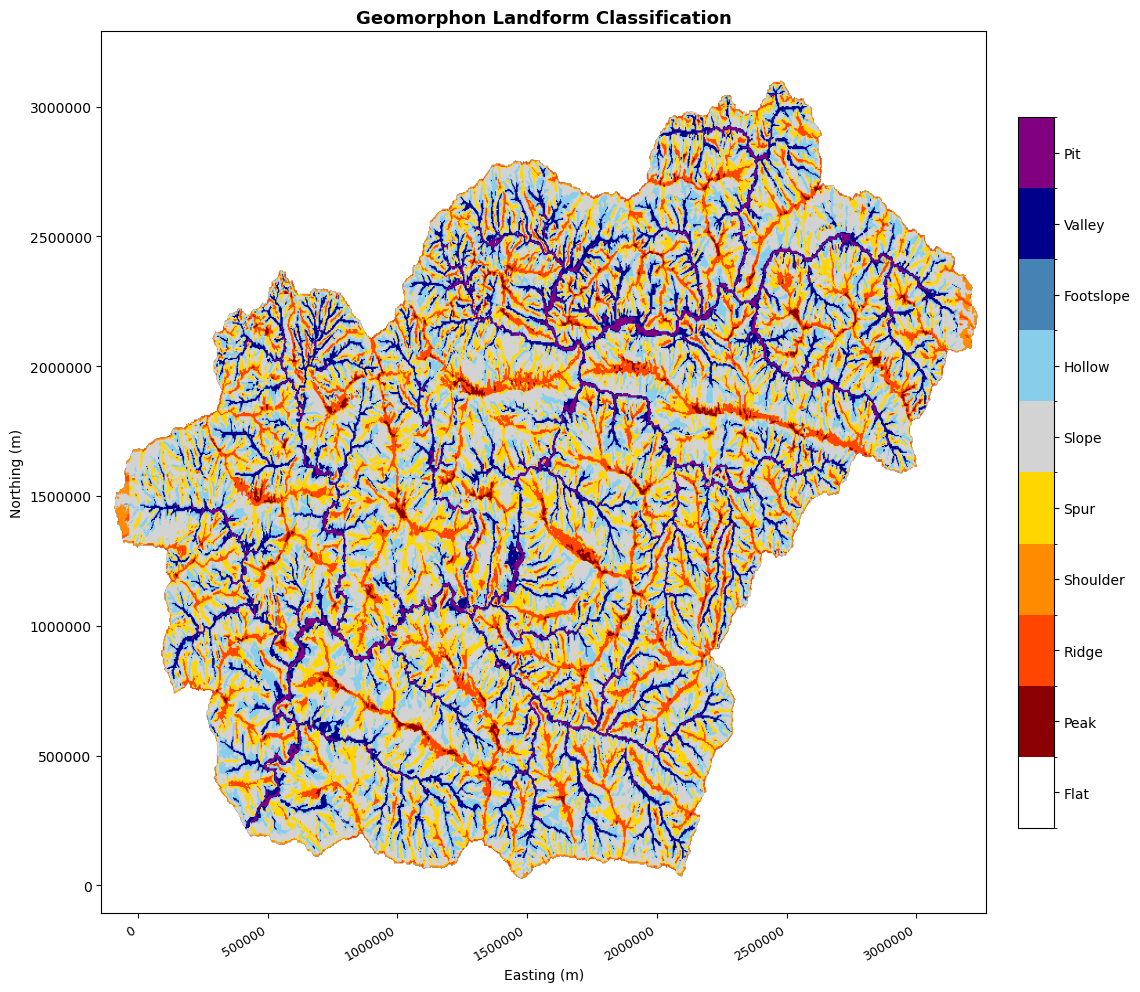

In [64]:
from rasterio.warp import transform_bounds
from pyproj import CRS

# Visualize Geomorphons with custom colormap and legend
with rasterio.open(geomorphons) as src:
    geomorph_data = src.read(1, masked=True)
    extent = transform_bounds(
        src.crs,
        CRS.from_epsg(32645),  # same UTM zone (safe even if already UTM)
        *src.bounds
    )

# Define geomorphon classes and colors
geomorph_classes = {
    1: ('Flat', '#FFFFFF'),
    2: ('Peak', '#8B0000'),
    3: ('Ridge', '#FF4500'),
    4: ('Shoulder', '#FF8C00'),
    5: ('Spur', '#FFD700'),
    6: ('Slope', '#D3D3D3'),
    7: ('Hollow', '#87CEEB'),
    8: ('Footslope', '#4682B4'),
    9: ('Valley', '#00008B'),
    10: ('Pit', '#800080')
}

# Create custom colormap
cmap_colors = [geomorph_classes[i][1] for i in range(1, 11)]
cmap = colors.ListedColormap(cmap_colors)
bounds = np.arange(0.5, 11.5, 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    geomorph_data,
    cmap=cmap,
    norm=norm,
    extent=extent,
    aspect='equal'
)

ax.set_title('Geomorphon Landform Classification', fontsize=13, fontweight='bold')
ax.set_xlabel('Easting (m)', fontsize=10)
ax.set_ylabel('Northing (m)', fontsize=10)
ax.ticklabel_format(style='plain', useOffset=False)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)

# Add legend
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.03, ticks=range(1, 11))
cbar.ax.set_yticklabels([geomorph_classes[i][0] for i in range(1, 11)])

plt.tight_layout()
plt.show()
plt.close()


### Interpreting Geomorphon Results

Convex features appear in warm colors. Peaks (dark red) are highest local points often used for viewsheds. Ridges (orange-red) are linear high features serving as watershed divides. Shoulders (dark orange) are upper convex slopes prone to erosion. Spurs (gold) are protruding ridges between valleys.

Transitional features appear in neutral colors. Slopes (light gray) are simple inclined surfaces. Flats (white) are level or nearly level terrain.

Concave features appear in cool colors. Hollows (light blue) are concave hillslope elements where flow converges. Footslopes (medium blue) are lower concave slopes with sediment accumulation. Valleys (dark blue) are linear low features serving as drainage channels. Pits (purple) are enclosed depressions.

## 5. Downslope Index - Measuring Downslope Influence

The Downslope Index calculates the average slope between each cell and all cells in its downslope flowpath, providing a measure of overall downslope gradient and potential energy available for sediment transport and water flow.

Unlike local slope which measures gradient between a cell and immediate neighbors, Downslope Index considers the entire path to the drainage network, capturing landscape position and connectivity. High values indicate upper hillslopes far from drainage with high erosion potential. Low values indicate valley bottoms near base level with deposition potential.

**WhiteboxTools Command**: `DownslopeIndex`

In [65]:
print("Calculating Downslope Index...\n")

# Output file
downslope_index = os.path.join(config['output_dir'], 'wb_downslope_index.tif')

# Calculate downslope index
run_whitebox_tool(
    tool_name='DownslopeIndex',
    parameters={
        'dem': filled_dem,
        'output': downslope_index
    }
)

print(f"\nDownslope Index saved to: {downslope_index}")

Calculating Downslope Index...


Downslope Index saved to: results/wb_downslope_index.tif


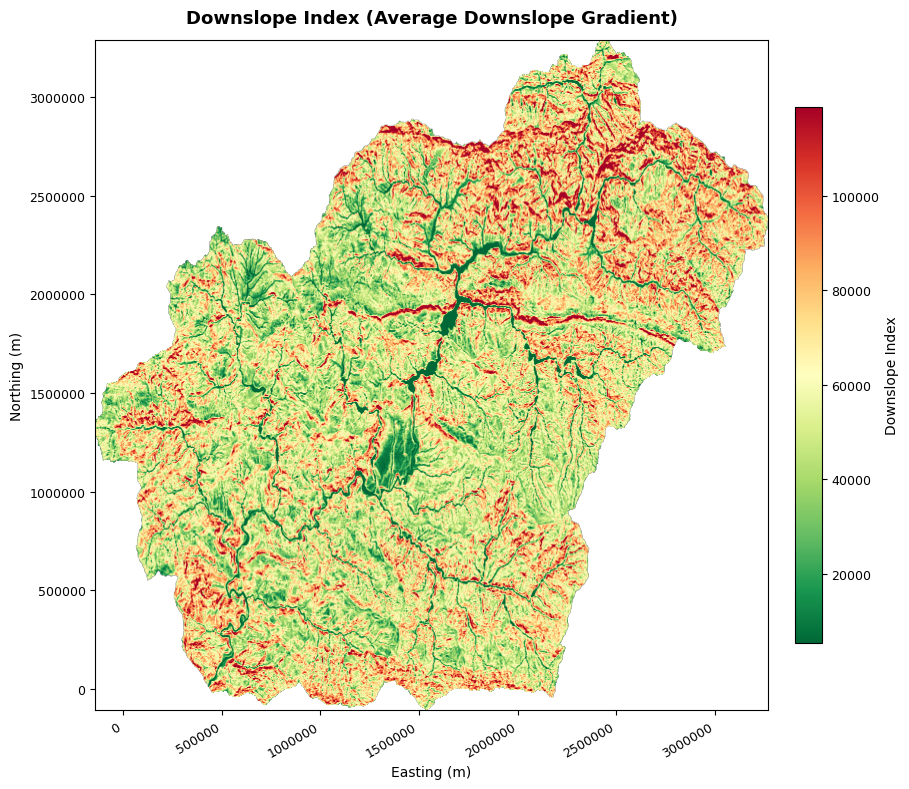

In [66]:
# Visualize
visualize_raster(
    downslope_index,
    title='Downslope Index (Average Downslope Gradient)',
    cmap='RdYlGn_r',
    percentile=(2, 98),
    colorbar_label='Downslope Index'
)

### Interpreting Downslope Index

Red and orange areas with high values indicate upper hillslopes and ridge tops with large elevation difference to the drainage network, high gravitational potential energy, and strong erosion potential serving as source areas for sediment and water. Yellow areas with moderate values indicate mid-slope positions with intermediate transport capacity serving as transfer zones. Green areas with low values indicate valley bottoms and channels with small elevation differences, low energy conditions, and deposition potential where transported material accumulates.

## Comparative Visualization

This cell creates a comprehensive comparison of all WhiteboxTools terrain and hydrological metrics side-by-side. The visualization helps identify relationships between different analyses and understand how various metrics highlight different aspects of the landscape hydrology and geomorphology.

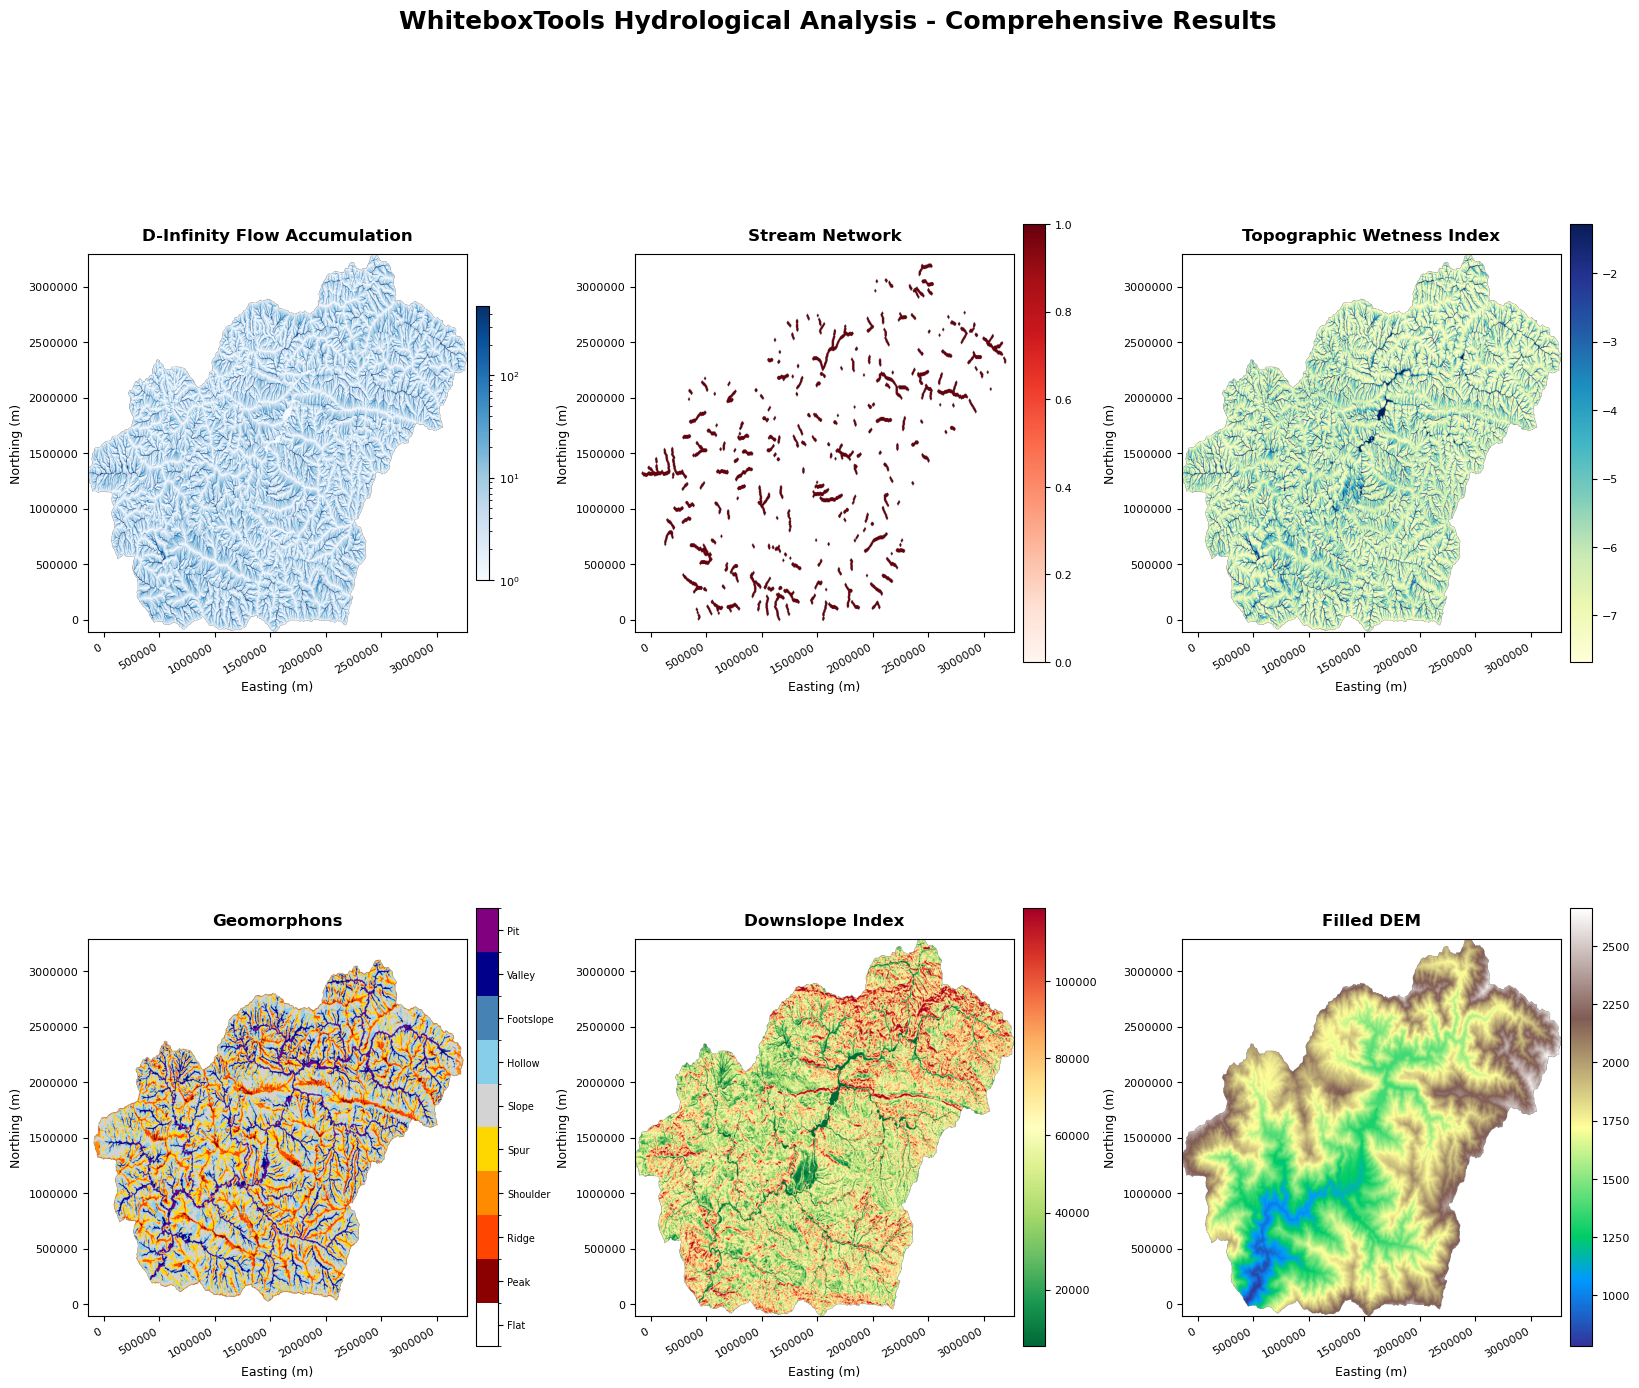


Comparison saved to: results/whitebox_terrain_comparison.png


In [69]:
from rasterio.warp import transform_bounds
from pyproj import CRS

# Create comprehensive comparison plot
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(2, 3, hspace=0.25, wspace=0.2)
fig.suptitle(
    'WhiteboxTools Hydrological Analysis - Comprehensive Results',
    fontsize=18,
    fontweight='bold',
    y=0.98
)

datasets = [
    (dinf_flow_accum, 'D-Infinity Flow Accumulation', 'Blues', True, (1, 99)),
    (streams, 'Stream Network', 'Reds', False, (0, 100)),
    (twi, 'Topographic Wetness Index', 'YlGnBu', False, (2, 98)),
    (geomorphons, 'Geomorphons', None, False, (0, 100)),  # Special handling
    (downslope_index, 'Downslope Index', 'RdYlGn_r', False, (2, 98)),
    (filled_dem, 'Filled DEM', 'terrain', False, (0, 100))
]

for idx, (filepath, title, cmap_name, use_log, percentiles) in enumerate(datasets):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])

    if not os.path.exists(filepath):
        ax.set_title(f"{title}\n(Missing file)", fontsize=10)
        ax.axis('off')
        continue

    # --- READ DATA + EXTENT FROM SAME SOURCE ---
    with rasterio.open(filepath) as src:
        data = src.read(1, masked=True)
        extent = transform_bounds(
            src.crs,
            CRS.from_epsg(32645),  # UTM zone
            *src.bounds
        )

    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]

    if title == 'Stream Network':
        from scipy.ndimage import binary_dilation
        stream_binary = (data > 0).astype(np.uint8)
        stream_dilated = binary_dilation(stream_binary, iterations=3)
        stream_display = np.ma.masked_where(stream_dilated == 0, stream_dilated)

        im = ax.imshow(
            stream_display,
            cmap='Reds',
            extent=extent,
            aspect='equal',
            vmin=0,
            vmax=1
        )
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

    elif title == 'Geomorphons':
        cmap_colors = [geomorph_classes[i][1] for i in range(1, 11)]
        cmap = colors.ListedColormap(cmap_colors)
        bounds = np.arange(0.5, 11.5, 1)
        norm = colors.BoundaryNorm(bounds, cmap.N)

        im = ax.imshow(
            data,
            cmap=cmap,
            norm=norm,
            extent=extent,
            aspect='equal'
        )
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02, ticks=range(1, 11))
        cbar.ax.set_yticklabels(
            [geomorph_classes[i][0] for i in range(1, 11)],
            fontsize=7
        )

    elif use_log and len(valid_data) > 0:
        positive_data = valid_data[valid_data > 0]
        if len(positive_data) > 0:
            vmin = np.percentile(positive_data, percentiles[0])
            vmax = np.percentile(positive_data, percentiles[1])
            norm = colors.LogNorm(vmin=max(vmin, 1), vmax=vmax)
            im = ax.imshow(
                data,
                cmap=cmap_name,
                extent=extent,
                aspect='equal',
                norm=norm
            )
        else:
            im = ax.imshow(
                data,
                cmap=cmap_name,
                extent=extent,
                aspect='equal'
            )
        cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

    else:
        if len(valid_data) > 0:
            vmin, vmax = np.percentile(valid_data, percentiles)
        else:
            vmin, vmax = 0, 1

        im = ax.imshow(
            data,
            cmap=cmap_name,
            extent=extent,
            aspect='equal',
            vmin=vmin,
            vmax=vmax
        )
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Easting (m)', fontsize=9)
    ax.set_ylabel('Northing (m)', fontsize=9)
    ax.ticklabel_format(style='plain', useOffset=False)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)

plt.tight_layout()
comparison_file = os.path.join(config['output_dir'], 'whitebox_terrain_comparison.png')
plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nComparison saved to: {comparison_file}")


## Summary Statistics

This cell computes comprehensive statistics (minimum, maximum, mean, standard deviation) for all terrain and hydrological metrics. The statistics help understand the range and distribution of values across the watershed.

In [70]:
import pandas as pd

stats_data = []

metrics = [
    (dinf_flow_accum, 'D-Infinity Flow Accum'),
    (twi, 'Topographic Wetness Index'),
    (downslope_index, 'Downslope Index'),
    (slope, 'Slope (degrees)')
]

for filepath, metric_name in metrics:
    if os.path.exists(filepath):
        stats = compute_statistics(filepath)
        stats_data.append({
            'Metric': metric_name,
            'Min': f"{stats['min']:.2f}",
            'Max': f"{stats['max']:.2f}",
            'Mean': f"{stats['mean']:.2f}",
            'Median': f"{stats['median']:.2f}"
        })

stats_df = pd.DataFrame(stats_data)
print("\nWhiteboxTools Terrain Metrics Summary:")
print(stats_df.to_string(index=False))


WhiteboxTools Terrain Metrics Summary:
                   Metric   Min       Max     Mean   Median
    D-Infinity Flow Accum  1.00   7464.76    24.19     3.30
Topographic Wetness Index -8.98     36.18    -5.91    -6.42
          Downslope Index  0.00 330668.25 60501.97 59646.75
          Slope (degrees)  0.00     69.10    28.36    28.93


## WhiteboxTools vs Other Platforms

WhiteboxTools stands out for several reasons. Its Rust implementation provides 5-10x faster performance than Python implementations with memory-efficient processing of large DEMs. The advanced hydrological algorithms include D-Infinity flow for more realistic hillslope modeling and breach depressions as an alternative to filling. Geomorphons provide a unique pattern-based approach not found in most other platforms.

WhiteboxTools complements other tools in this workshop series: SAGA excels at general terrain analysis, GRASS provides extensive geomorphometry capabilities, and OTB offers image processing. Using multiple platforms together provides comprehensive analysis capabilities.

## Summary

This tutorial demonstrated WhiteboxTools' hydrological and geomorphometric analysis capabilities. Flow Accumulation using D-Infinity provides realistic multi-directional flow modeling. Stream Network extraction automates drainage channel identification. TWI predicts moisture accumulation patterns for ecology and hydrology applications. Geomorphons provide automated pattern-based landform classification. Downslope Index measures gravitational potential and landscape connectivity.

These metrics complement the terrain analyses from Notebooks 04-06. Together, the seven notebooks in this workshop series demonstrate a complete FOSS4G workflow from DEM acquisition through advanced terrain and hydrological analysis.